# Machine Learning Pipeline

In this notebook, we are going to build a pipeline for a general prediction problem.

In [1]:
# Standard Imports
from src.utils import *
from src.get_feature_names import get_feature_names

In [2]:
# Set inline graphs
plt.style.use('seaborn')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introduction

Usually, in machine learning prediction tasks, the data consists in 3 files:

 - *X_train.csv*
 - *y_train.csv*
 - *X_test.csv*
 
The purpose of the exercise is to produce a *y_test.csv* file, with the predicted values corresponding to the *X_test.csv* observations.

The functions we will write are going to be general and will adapt to any type of dataset, and we will test them on the [House Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) which is a standard dataset for these kind of tasks. The data consists of 2 files:

 - *train.csv*
 - *test.csv*

The target variable that we want to predict is `SalePrice`.

## Setup

First we want to import the data.

In [3]:
# Import data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

print(f"Training data: {np.shape(df_train)} \n Testing data: {np.shape(df_test)}")

Training data: (1460, 81) 
 Testing data: (1459, 80)


The training data also includes the target variable `SalePrice`, while, as usual, the testing data does not. We need to separate the training data into two parts:

- `X`: the **features**
- `y`: the **target**

In [4]:
# Select the features
X_train = df_train.drop(['SalePrice'], axis=1)
X_test = df_test

# Check size
print(f"Training features: {np.shape(X_train)} \n Testing features: {np.shape(X_test)}")

Training features: (1460, 80) 
 Testing features: (1459, 80)


In [5]:
# Select the target
y_train = df_train['SalePrice']

# Check size
print(f"Training target: {np.shape(y_train)}")

Training target: (1460,)


It's good practice to immediately set aside a **validation** sample with 20% of the observations. The purpose of the validation sample is to give us unbiased estimate of the prediction score. Therefore, we want to set it aside as soon as possible, not to be conditioned in any way by it. Possibly, set it away even before data exploration.


The more we tune the algorithm based on the feedback received from the validation sample, the more biased our estimate is going to be. Ideally, one would use only cross-validation on the training data and tune only a couple of times using the validation data.

In [6]:
# Set aside the validation sample
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

Now we are ready to build and test our pipeline.

## Data Exploration

First, let's have a quick look at the data.

In [7]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
822,823,60,RL,NaN,12394,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2007,WD,Family
648,649,60,RL,70.0,7700,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
897,898,90,RL,64.0,7018,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Alloca
1131,1132,20,RL,63.0,10712,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,9,2007,Oth,Abnorml
1038,1039,160,RM,21.0,1533,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal


The `Id` column is clearly not useful for prediction, let's drop it from both datasets.

In [8]:
# Drop Id 
X_train.drop(["Id"], axis=1, inplace=True)
X_test.drop(["Id"], axis=1, inplace=True)

Now we want to identify categorical and numerical variables.

In [9]:
# Save column types
numerical_cols = list(X_train.describe().columns)
categorical_cols = list(X_train.describe(include=object).columns)
print("There are %i numerical and %i categorical variables" % (len(numerical_cols), len(categorical_cols)))

There are 36 numerical and 43 categorical variables


Let's start by analyzing the numerical variables. 

In [10]:
X_numerical = X_train.loc[:, numerical_cols]
corr = X_numerical.corr()

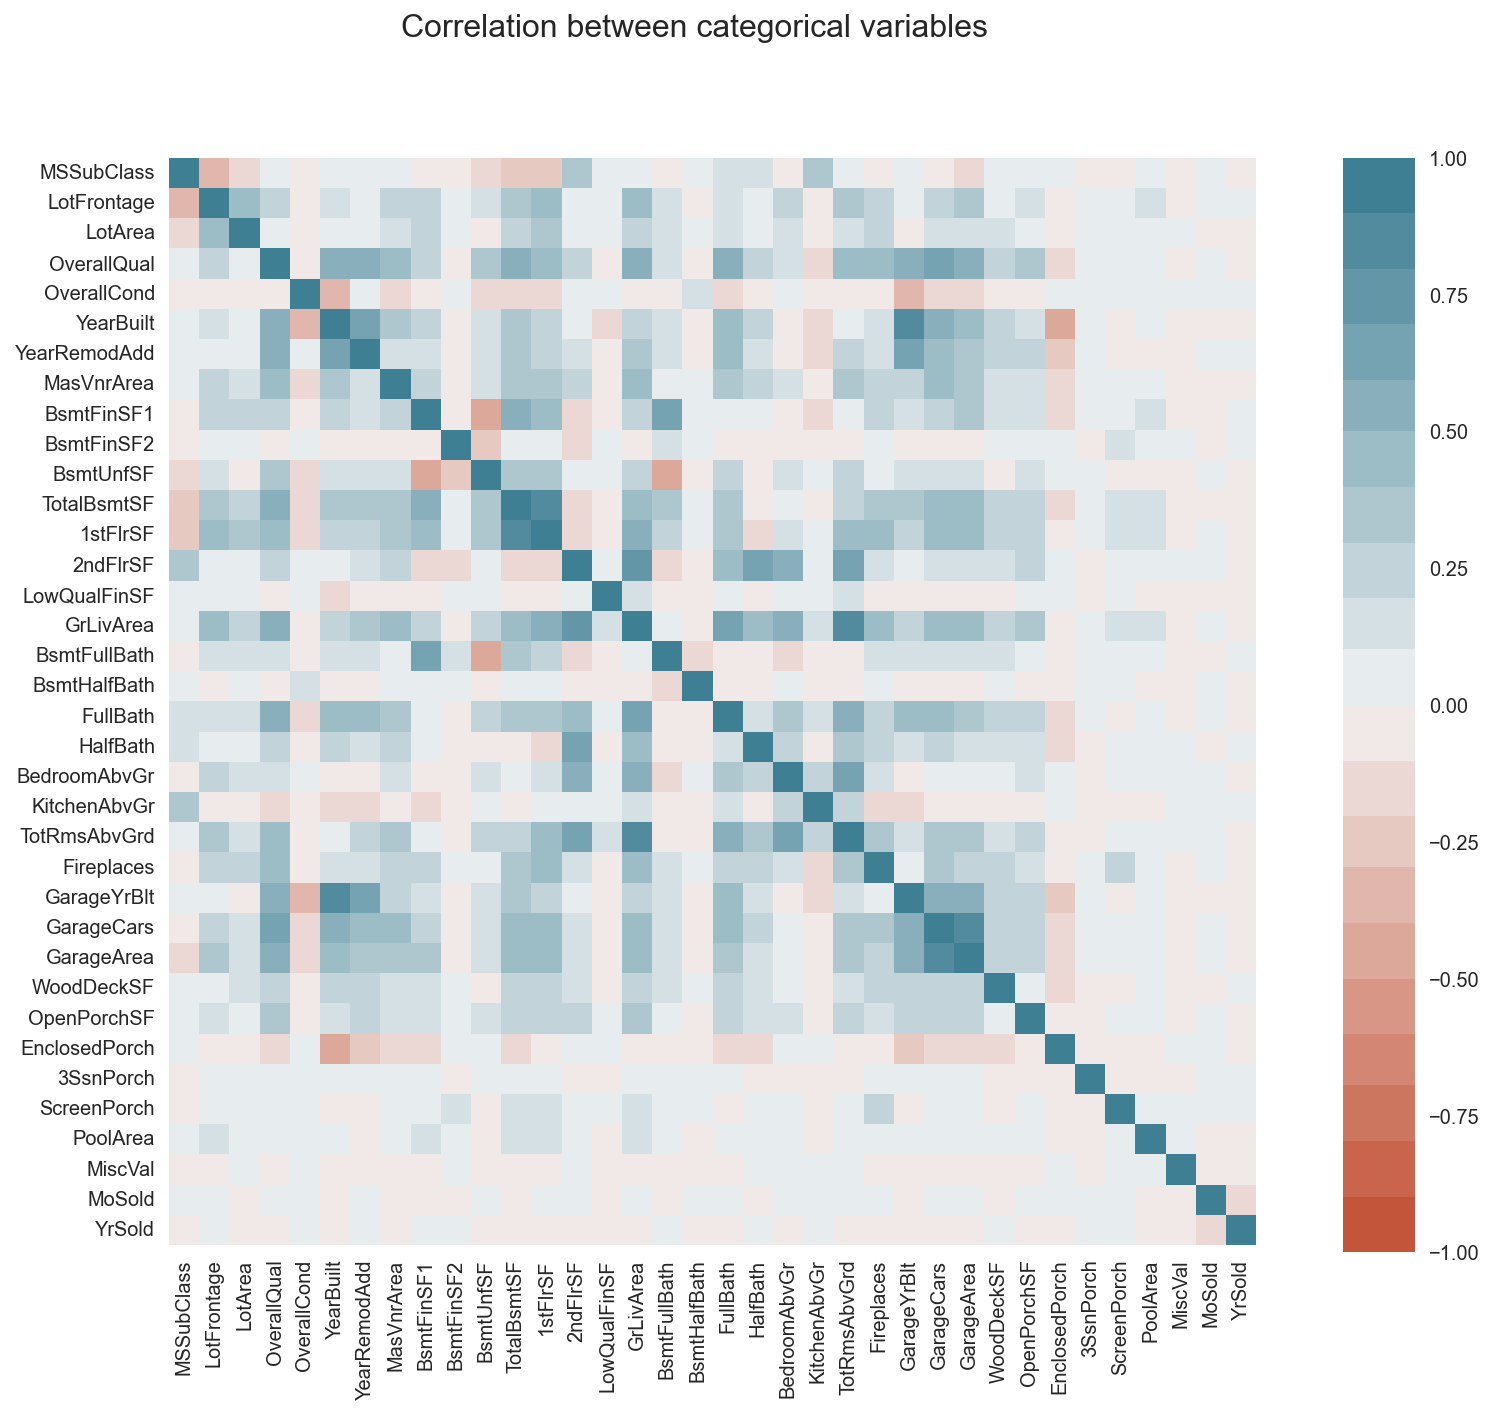

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle("Correlation between categorical variables", fontsize=16)
cbar_ax = fig.add_axes([.95, .12, .05, .76])
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=20), 
            square=True, ax=ax, cbar_ax = cbar_ax)
plt.show()

For the non/numeric columns, we need a further option.

In [12]:
unique_values = X_train.describe(include=object).T.unique

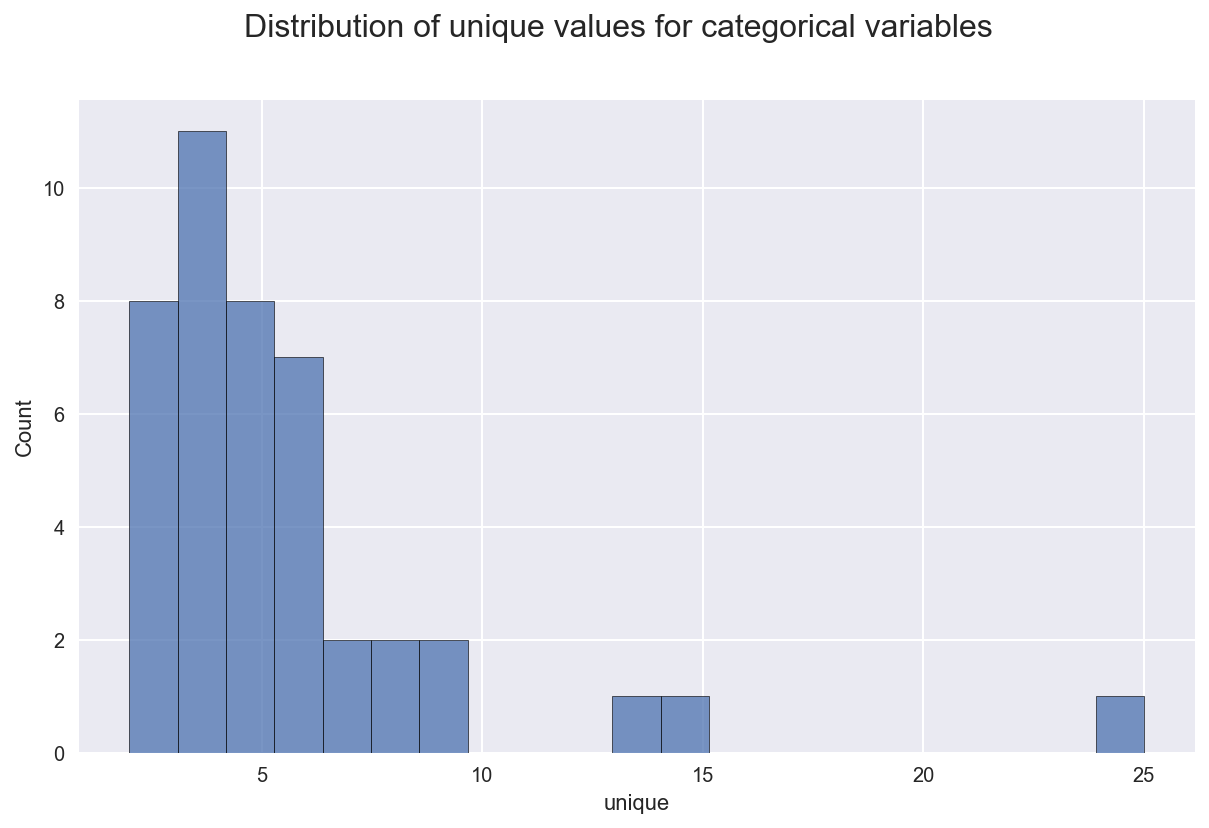

In [13]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,6))
fig.suptitle("Distribution of unique values for categorical variables", fontsize=16)
sns.histplot(data=unique_values)
plt.show();

Let's save the identity of the numerical and categorical columns.

In [14]:
# Save column types
numerical_cols = list(X_train.describe().columns)
categorical_cols = list(X_train.describe(include=object).columns)

How many missing values are there in the dataset?

In [15]:
missing_values = X_train.isnull().sum().sort_values(ascending=True)[-20:] / len(X_train)

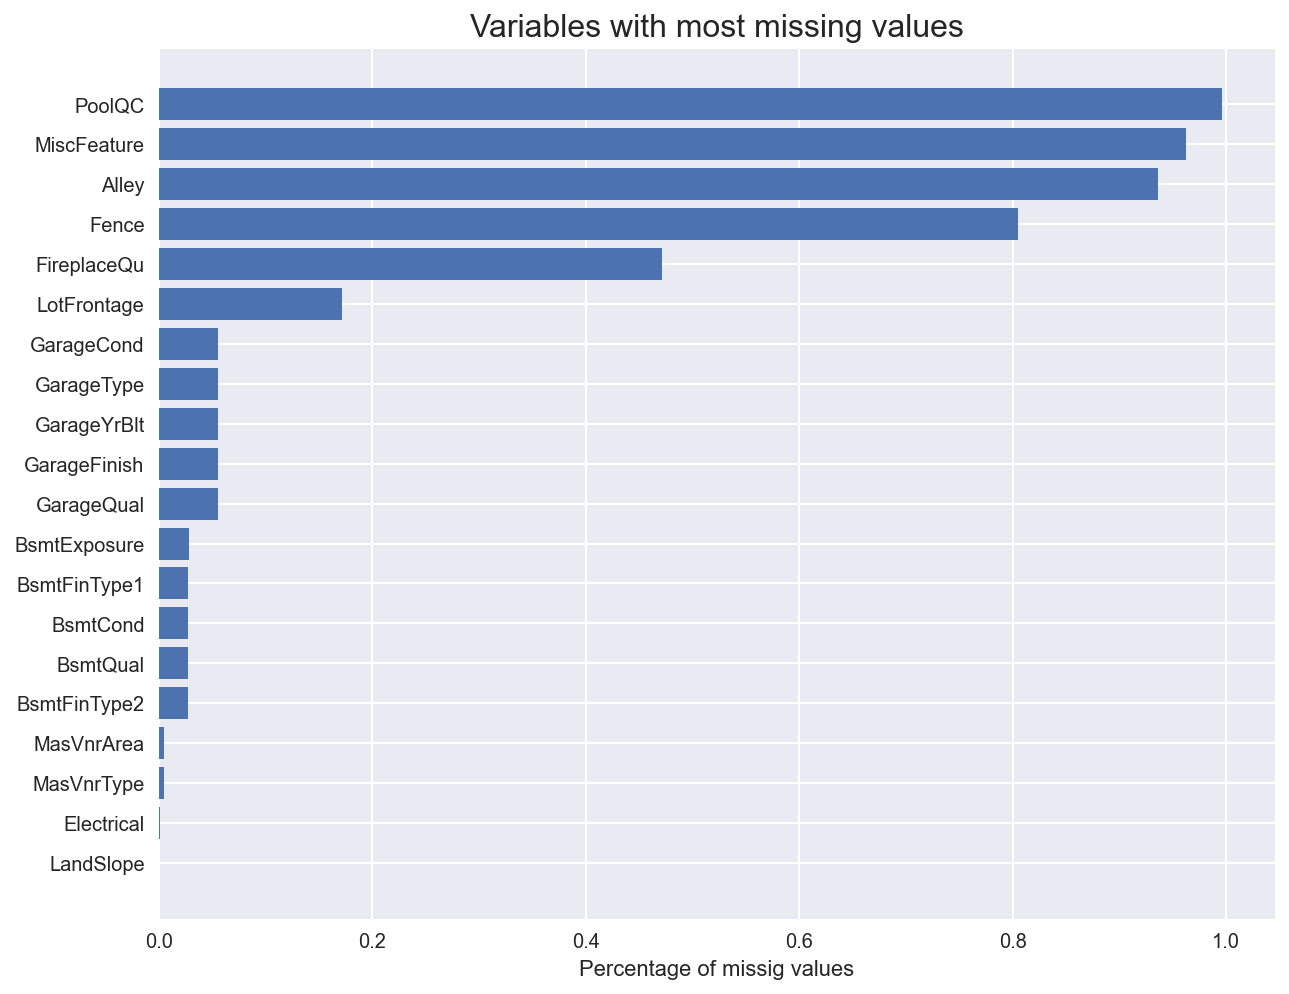

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Variables with most missing values", fontsize=16)
ax.barh(np.arange(len(missing_values)), missing_values)
ax.set_yticks(np.arange(len(missing_values)))
ax.set_yticklabels(missing_values.index)
ax.set_xlabel('Percentage of missig values')
plt.show()

Around 10% of each feature is missing. We will have to deal with that.

## Pre-processing

First, let's process **numerical variables**. We want to do two things:

- inpute missing values
- standardize all variables

Which imputer should to use? It depends on the **type of missing data**:

- **Missing absolutely at random**: as the name says, in this case we believe that missing values are distributed uniformly at random, independently across variables. 
    - In this case, the only information on missing values comes from the distribution of non-missing values of the same variable. 
    - No information on missing values is contained in other variables.


- **Missing at random**: in this case, missing values are random, conditional on values of other observed variables. 
    - In this case, information in other variables might help filling missing values.


- **Missing non at random**: in this last case, missing values depend on information that we do not observe. 
    - This is the most tricky category of missing values since data alone does not tell us which values might be missing. For example, we might have that older women might be less likely to report the age. 
    - If we consider the data missing at random (absolutely or not), we would underestimate the missing ages. 
    - External information such as the sample population might help. For example, we could estimate the probability of not reporting the age and fill the missing values with the expected age, *conditional* on age not being reported.

So, which imputers are readily available in `sklearn` for numerical data?

For data **missing absolutely at random**, there is one standard `sklearn` library: `SimpleImputer()`. It allows different `strategy` options such as 

- `"mean"`
- `"median"`
- `"most_frequent"`

For data **missing at random**, there are multiple `sklearn` libraries:
 - `KNNImputer()`: uses KNN
 - `IterativeImputer()`: uses a variety of ML algorithms
     - see comparison [here](https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html)

After we have inputed missing values, we want to standardize numerical variables to make the algorithm more efficient and robust to outliers.

The two main options for standardization are:

- `StandardScaler()`: which normalizes each variable to mean zero and unit variance
- `MinMaxScaler()`: which normalizes each variable to an interval between zero an one

In [17]:
# Inputer for numerical variables
num = Pipeline(steps=[
    ('ii', IterativeImputer()),
    ('ss', StandardScaler())
    ])

For **categorical variables**, we do not have to worry about scaling. However, we still need to impute missing values and, crucially, we need to transform them into numerical variables. This process is called **encoding**.

Which imputer should to use? 

For data **missing absolutely at random**, the only available `strategy` option for `SimpleImputer()` is

- `"most_frequent"`

For data **missing at random**, we can still use both
 - `KNNImputer()`
 - `IterativeImputer()`

For **encoding** categorical variables, the standard option is `OneHotEncoder()` which generates unique binary variables out of every values of the categorical variable.

In [18]:
# One Hot Encoder for categorical data
cat = Pipeline(steps=[
    ('si', SimpleImputer(strategy="most_frequent")),
    ('ohe', OneHotEncoder(handle_unknown="ignore")),
    ])

In [19]:
# Preprocess column transformer for preprocessing data
preprocess = ColumnTransformer(
                    transformers=[
                        ('num', num, numerical_cols),
                        ('cat', cat, categorical_cols),
                    ])

## Information and components

How much information is contained in our dataset? It is a dense or sparse dataset?

In [20]:
X_clean = num.fit_transform(X_numerical)
pca = PCA().fit(X_clean)
explained_variance = pca.explained_variance_ratio_

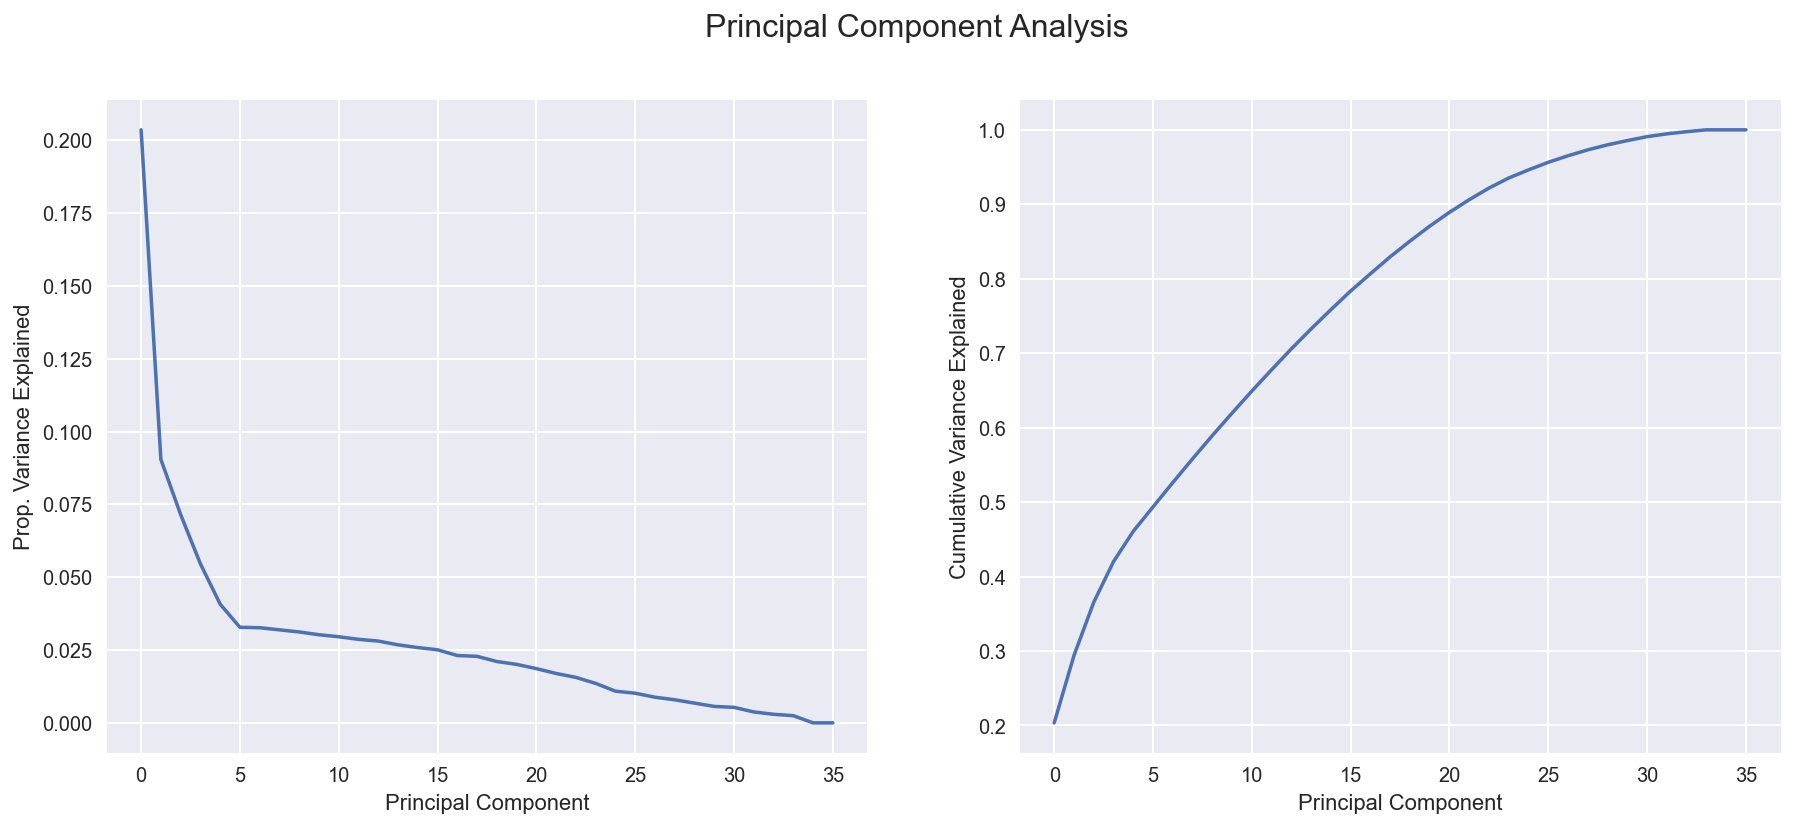

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Principal Component Analysis', fontsize=16);

# Relative 
ax1.plot(range(len(explained_variance)), explained_variance)
ax1.set_ylabel('Prop. Variance Explained')
ax1.set_xlabel('Principal Component');

# Cumulative
ax2.plot(range(len(explained_variance)), np.cumsum(explained_variance))
ax2.set_ylabel('Cumulative Variance Explained');
ax2.set_xlabel('Principal Component');

## Feature Importance

Before starting our prediction analysis, we would like to understand which variables are most important for our prediction problem.

In [22]:
def plot_featureimportance(importance, preprocess):
    df = pd.DataFrame({"names": get_feature_names(preprocess), "values": importance})
    df = df.sort_values("values").iloc[:20, :]
    # plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_title("Feature importance", fontsize=16)
    sns.barplot(y="names", x="values", data=df)
    ax.barh(np.arange(len(df)), df["values"])
    plt.show()

We start with linear regression feature importance: we standardize all variables to be mean vero and unit variance, and we run a linear regression over the test set.

In [23]:
def featureimportance_lr(X, y):
    X_clean = preprocess.fit_transform(X)
    # fit the model
    model = LinearRegression()
    model.fit(X_clean, y)
    # get importance
    importance = np.abs(model.coef_)
    plot_featureimportance(importance, preprocess)

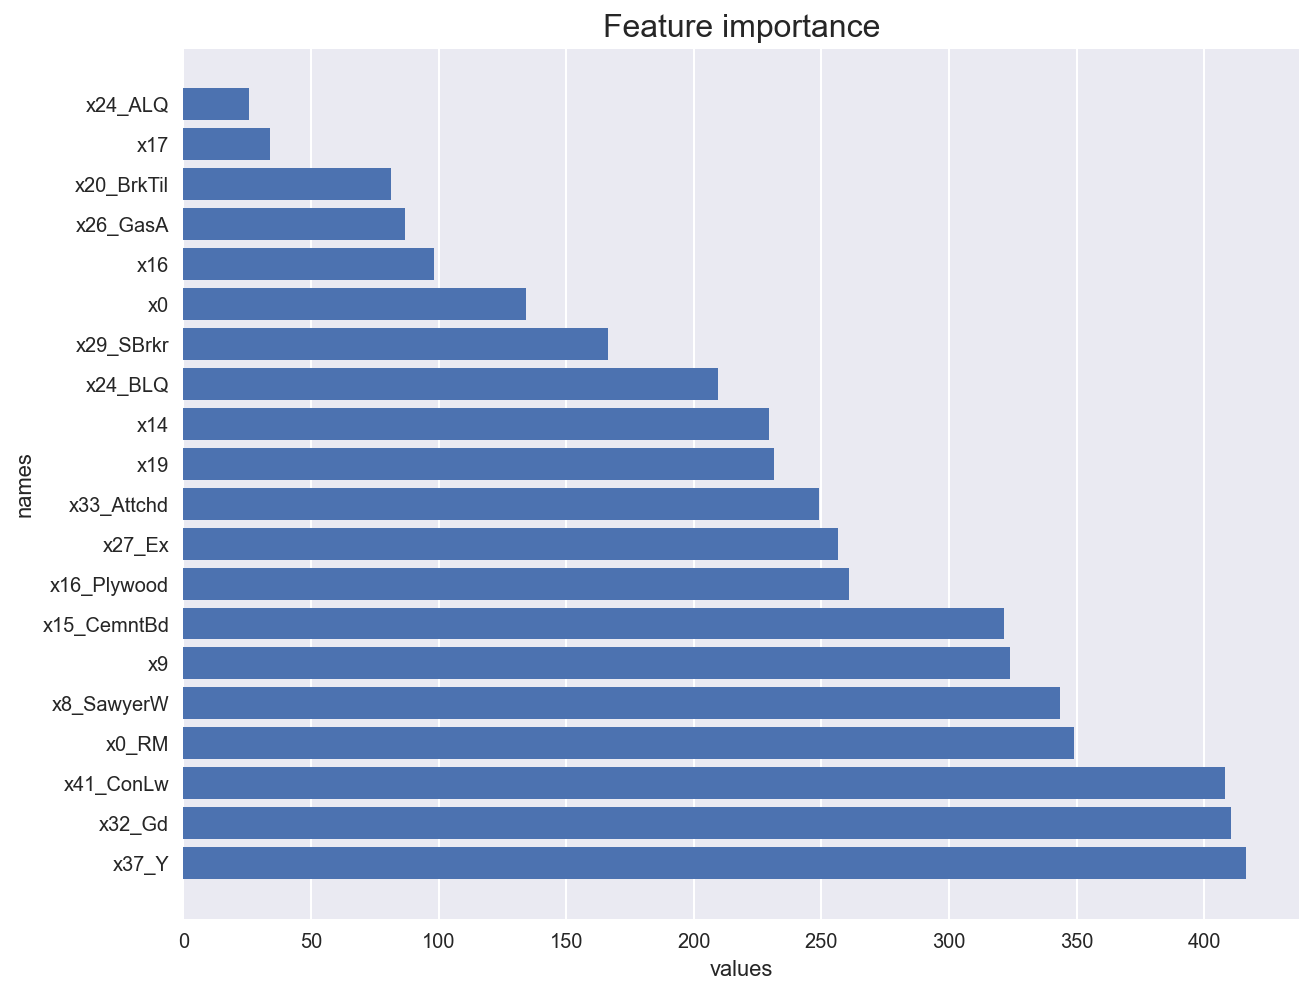

In [24]:
# Plot linear feature importance
featureimportance_lr(X_train, y_train)

We now look at regression tree feature importance.

In [25]:
def featureimportance_forest(X, y):
    X_clean = preprocess.fit_transform(X)
    # fit the model
    model = RandomForestRegressor()
    model.fit(X_clean, y)
    # get importance
    importance = model.feature_importances_
    plot_featureimportance(importance, preprocess)

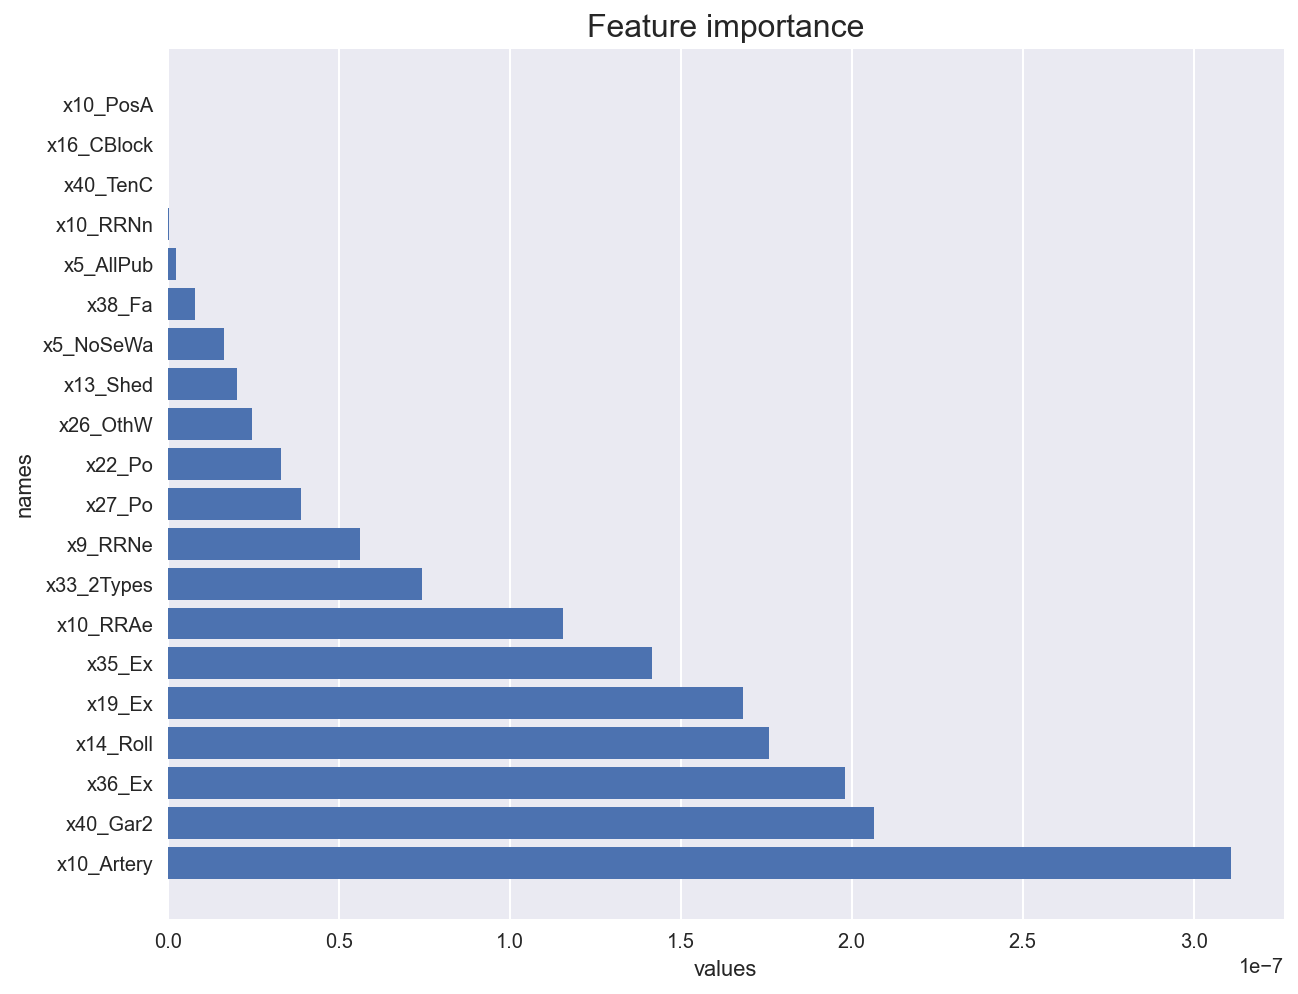

In [26]:
# Plot tree feature importance
featureimportance_forest(X_train, y_train)

## Weighting

Another important check to perform concerns weighting. Is the distribution of our objective variable the same in the training and in the test sample? If it is not the case, we might get a poor performance just because our training sample is not representative of our testing sample.

This is something that usually **we cannot test**, since we do not have access to the distribution of the target variable in the test data. However, we might be given the information ex-ante as a warning.

In this case, we perform the analysis on the validation set. Since we have selected the validation set at random, we do not expect significant differences.

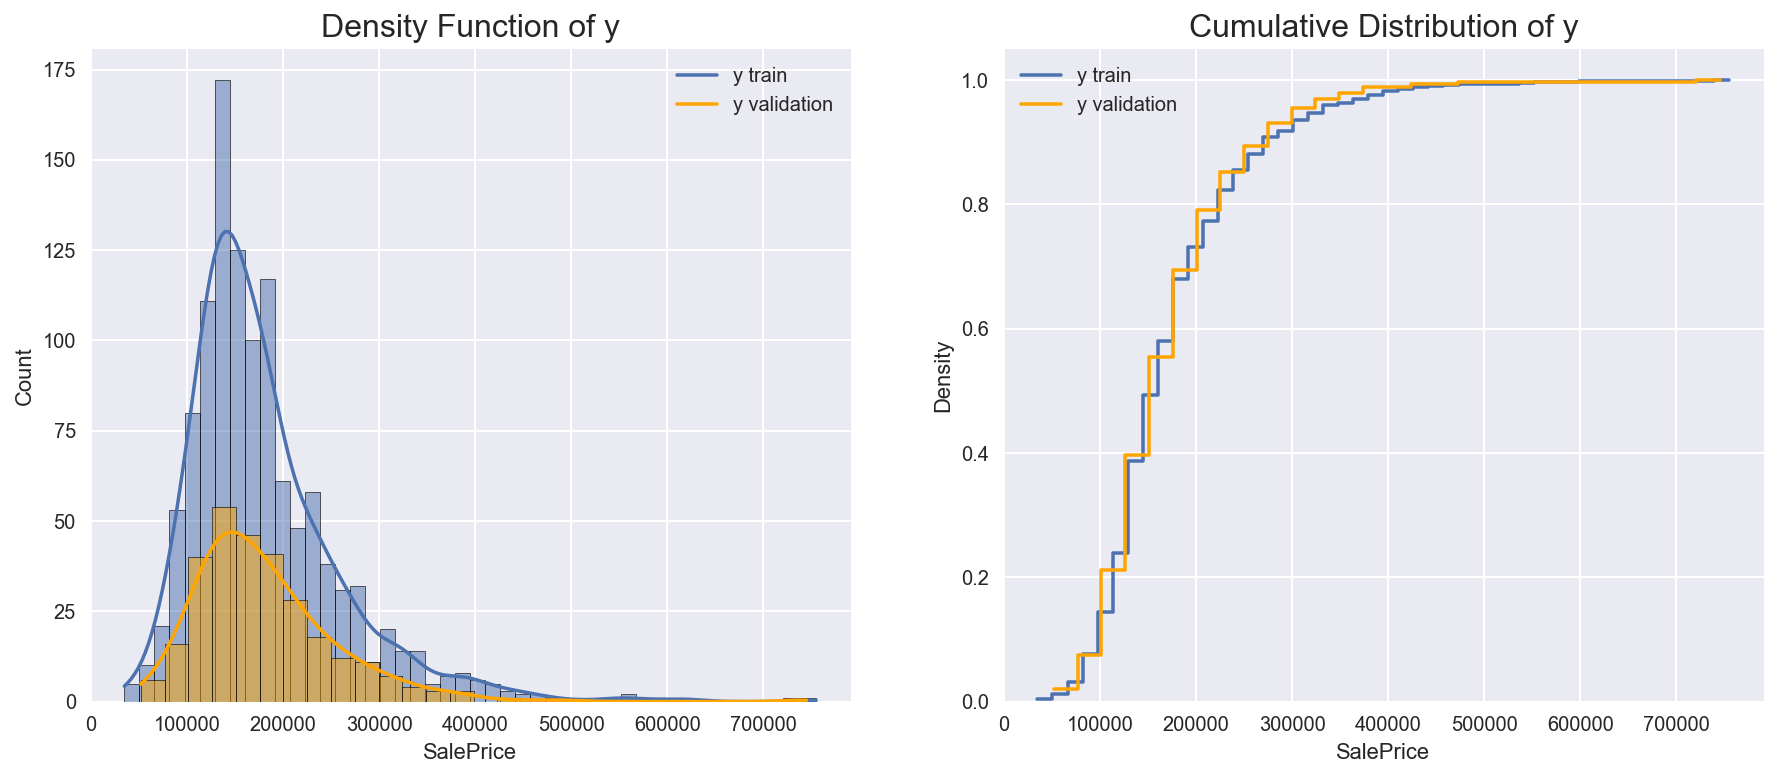

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Plot 1
sns.histplot(data=y_train, kde=True, ax=ax1)
sns.histplot(data=y_validation, kde=True, ax=ax1, color='orange')
ax1.set_title("Density Function of y", fontsize=16);
ax1.legend(['y train', 'y validation'])

# Plot 2
sns.histplot(data=y_train,  element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, ax=ax2)
sns.histplot(data=y_validation, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False, ax=ax2, color='orange')
ax2.set_title("Cumulative Distribution of y", fontsize=16);
ax2.legend(['y train', 'y validation']);

Since the size of the test sample is smaller than the size of the training sample, the two densities are different. However, the distributions indicate that the standardized distributions are the same.

## Model

There are many models to choose among.

In [28]:
# prepare models
models = {"Lasso": Lasso(alpha=100),
          "Ridge": BayesianRidge(),
          "KNN": KNeighborsRegressor(),
          "Kernel": KernelRidge(),
          "Naive": GaussianNB(),
          "SVM": SVR(),
          "Ada": AdaBoostRegressor(),
          "Tree": DecisionTreeRegressor(),
          "Forest": RandomForestRegressor(),
          "GBoost": GradientBoostingRegressor(),
          "XGBoost": XGBRegressor(),
          "LGBoost": LGBMRegressor()}

In [29]:
def evaluate_model(model, name, X, y, cv, scoring):
    X_clean = preprocess.fit_transform(X)
    start = time.perf_counter()
    cv_results = cross_val_score(model, X_clean, y, cv=cv, scoring=scoring)
    t = time.perf_counter()-start
    score = {"model":name, "mean":-np.mean(cv_results), "std":np.std(cv_results), "time":t}
    print("%s: %f (%f) in %f seconds" % (name, -np.mean(cv_results), np.std(cv_results), t))
    return score

In [30]:
def plot_model_scores(scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle("Comparing algorithms", fontsize=16)
    
    # Plot 1
    scores.sort_values("mean", ascending=False, inplace=True)
    ax1.set_title("Mean squared error", fontsize=16)
    ax1.barh(range(len(scores)), scores["mean"], xerr=scores["std"])
    ax1.set_yticks(range(len(scores)))
    ax1.set_yticklabels([s for s in scores["model"]])
    
    # Plot 2
    scores.sort_values("time", ascending=False, inplace=True)
    ax2.set_title("Time", fontsize=16)
    ax2.barh(range(len(scores)), scores["time"], color='tab:orange')
    ax2.set_yticks(range(len(scores)))
    ax2.set_yticklabels([s for s in scores["model"]])
    plt.show()

In [31]:
def compare_models(models):
    scores = pd.DataFrame()
    cv = KFold(n_splits=5)
    scoring = 'neg_mean_squared_error'
    for name, model in models.items():
        score = evaluate_model(model, name, X_validation, y_validation, cv, scoring)
        scores = scores.append(score, ignore_index=True)
    return scores

In [32]:
scores = compare_models(models)

Lasso: 747411443.913101 (462917309.181485) in 0.109821 seconds
Ridge: 718774315.061634 (487089023.387329) in 0.472070 seconds
KNN: 1756639001.600806 (1476470798.673143) in 0.019063 seconds
Kernel: 844681295.934677 (476183041.447080) in 0.085055 seconds
Naive: 5254835359.080946 (2916476370.114636) in 0.045415 seconds
SVM: 6141030577.726756 (3241262535.954060) in 0.046852 seconds
Ada: 1513638885.120911 (1332241015.479751) in 0.306255 seconds
Tree: 3258264310.733547 (2139525308.773295) in 0.018476 seconds
Forest: 1324403652.968275 (1246235286.003631) in 1.105161 seconds
GBoost: 1200654655.518314 (1053677796.098979) in 0.494536 seconds
XGBoost: 1819197282.034136 (1587393748.901112) in 0.692401 seconds
LGBoost: 1318077152.379926 (1278188928.507894) in 0.157495 seconds


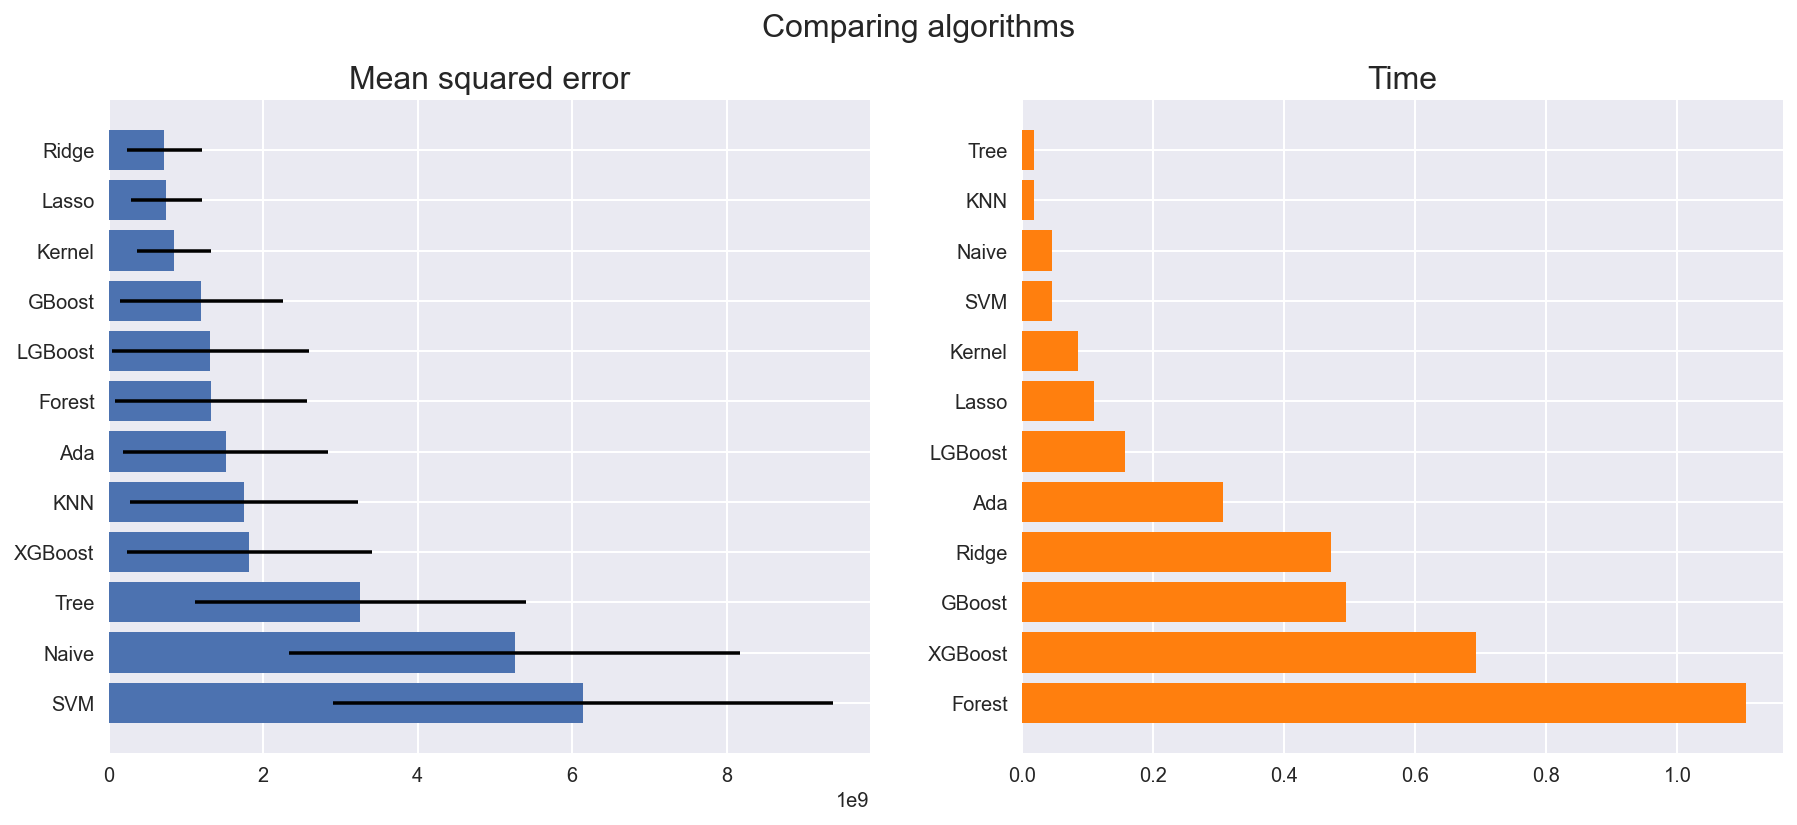

In [33]:
plot_model_scores(scores)

## Pipeline

We are now ready to pick a model.

In [34]:
# Set model
model = LGBMRegressor()

We need to choose a cross-validation procedure to test our model.

In [35]:
cv = KFold()

Finally, we can combine all the parts into a single pipeline.

In [36]:
final_pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', model)
        ])

Now we can decide which parts of the pipeline to test.

In [37]:
# Select parameters to explore
param_grid = {'preprocess__num__ii': [SimpleImputer(), KNNImputer(), IterativeImputer()],
              'preprocess__cat__si__strategy': ["most_frequent", "constant"],
              'model__learning_rate': [0.1, 0.2],
              'model__subsample': [1.0, 0.5],
              'model__max_depth': [30, -1]}

We now generate a grid of parameters we want to search over.

In [38]:
# Save pipeline
grid_search = GridSearchCV(final_pipeline, 
                           param_grid, 
                           cv=cv,
                           n_jobs=-1, 
                           scoring='neg_mean_squared_error',
                           verbose=3)

We fit the pipeline and pick the best estimator, from the cross-validation score.

In [39]:
# Fit pipeline
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ii',
                                                                   KNNImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                              

We have three ways of testing the quality of fit of our model:
 - score on the training data
 - score on the validation data
 - score on the test data

**Score on the training data**: this is a biased score since we have picked the model that was best fitting the training data. Kfold cross-validation is efficient in terms of data use, but still evaluates the model over the same data it was trained. 

In [40]:
# Cross/validation score
y_train_hat = grid_search.best_estimator_.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_hat, squared=False)
print('RMSE on training data :', train_rmse)

RMSE on training data : 12151.309344378069


**Score on the validation data**: this is an unbiased score since we have left out this sample exactly for this purpose. However, be aware that the validation score is unbiased on on the first run. Once we change the grid and pick the algorithm based on previous validation data scores, also this score becomes biased.

In [41]:
# Validation set score
y_validation_hat = grid_search.best_estimator_.predict(X_validation)
validation_rmse = mean_squared_error(y_validation, y_validation_hat, squared=False)
print('RMSE on validation data :', validation_rmse)

RMSE on validation data : 27676.358798908263


**Final predictions**: we can now use our model to output the predictions.

In [42]:
# Validation score
y_test_hat = grid_search.best_estimator_.predict(X_test)